### Variational Autoencoder

In [1]:
from MLP_VAE import train, train_vae, Dense, Dense_vae, predict_with_layer_value, predict, reparameterize, vae_loss
from activation_functions import Sigmoid
from MLP_VAE import mse, mse_derivative
from utils import fonts_to_bitmap, bitmap_as_matrix, get_config_params, train_different_architectures
from plots import *
from font import fontDict
import numpy as np
import matplotlib.pyplot as plt

# Load fonts

In [2]:
# Load fonts into list of bitmaps
bitmap_dict = fonts_to_bitmap(fontDict)
bitmap_list = list(bitmap_dict.values())  
bitmap_labels = list(bitmap_dict.keys())

X = np.reshape(bitmap_list,(len(bitmap_list), 35, 1))
Y = np.array(bitmap_labels)

#X = np.reshape(X,(len(X), 35))
#X = X.astype(np.float32)
print(X.shape)

(32, 35, 1)


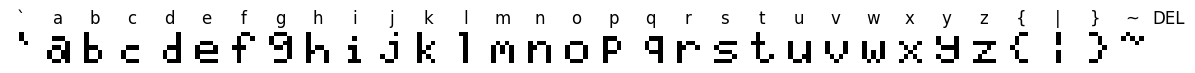

In [3]:
# Reshape each element of X to 7x5
reshaped_X = np.reshape(X, (len(X), 7, 5))

# Create a subplot with 1 row and as many columns as elements in X
fig, axs = plt.subplots(1, len(X), figsize=(12, 6))

# Plot each element of reshaped_X in a separate subplot
for i in range(len(X)):
    axs[i].imshow(reshaped_X[i], cmap='gray_r')
    axs[i].axis('off')
    axs[i].set_title(Y[i])  # Set the title to the corresponding label from Y

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Autoencoder

In [4]:
# Retrieve parameters from config file
learning_rate, max_epochs, bias, beta1, beta2, epsilon, optimizer, activation = get_config_params('ejercicio2_config.json')

mse_list = []

In [8]:
# The latent space is the output of "layer 6"
def generate_vae():
    encoder = [
        Dense_vae(35, 20, optimizer_type=optimizer, learning_rate=learning_rate),
        Sigmoid(),
        Dense_vae(20, 10, optimizer_type=optimizer, learning_rate=learning_rate),
        Sigmoid(),
        Dense_vae(10, 2, optimizer_type=optimizer, learning_rate=learning_rate),  # mu layer
        Dense_vae(10, 2, optimizer_type=optimizer, learning_rate=learning_rate, output_type='logvar'),  # logvar layer
    ] 

    decoder = [
        Dense_vae(2, 10, optimizer_type=optimizer, learning_rate=learning_rate),
        Sigmoid(),
        Dense_vae(10, 20, optimizer_type=optimizer, learning_rate=learning_rate),
        Sigmoid(),
        Dense_vae(20, 35, optimizer_type=optimizer, learning_rate=learning_rate),
        Sigmoid(),
    ]

    return encoder, decoder

In [9]:
wrong_dict = {}

def is_same_pixel(pixel1, pixel2):
    return round(pixel1) == round(pixel2)

def compare_bitmaps(input_bitmap, output_bitmap, character, max_wrongs = 1):
    wrongs = 0  
    for i in range(7*5):
        if not is_same_pixel(input_bitmap[i], output_bitmap[i]):
            print(f"Pixel {i} of '{character}' is different: {input_bitmap[i]} != {output_bitmap[i]}")
            wrongs += 1
            if wrongs > max_wrongs:
                return False
            wrong_dict[character] = i
    
    return True

In [10]:
characters = list(bitmap_dict.keys())
#print(characters)

epochs = 5000
#max_error = 0.02

# Generate VAE
encoder, decoder = generate_vae()

# Train VAE
losses = train_vae(encoder, decoder, X, epochs=epochs, verbose=True)

# Print final loss
print(f"Final Loss: {losses[-1]}")

train_vae input:  x_train shape:  (32, 35, 1) 

train_vae output shape:  (35, 1) 

Dense_vae.forward input shape: (35, 1)
train_vae output shape:  (20, 1) 

train_vae output shape:  (20, 1) 

Dense_vae.forward input shape: (20, 1)
train_vae output shape:  (10, 1) 

train_vae output shape:  (10, 1) 

Dense_vae.forward input shape: (10, 1)
train_vae output shape:  (2, 1) 

Dense_vae.forward input shape: (2, 1)


ValueError: shapes (2,10) and (2,1) not aligned: 10 (dim 1) != 2 (dim 0)

In [ ]:
# Evaluate the VAE
latent_spaces = []
raw_latent_spaces = []
input_matrix_list = []
output_matrix_list = []
correct = 0

for c in range(len(characters)):
    input_bitmap = []
    output_bitmap = []

    for i in range(len(X[c])):
        input_bitmap.append(X[c][i][0])
    input_matrix_list.append(bitmap_as_matrix(input_bitmap))

    # Get the latent space representation
    output = X[c]
    for layer in encoder:
        output = layer.forward(output)
        if isinstance(layer, Dense) and layer.output_type == 'mu':
            mu = output
        elif isinstance(layer, Dense) and layer.output_type == 'logvar':
            logvar = output
    z = reparameterize(mu, logvar)
    raw_latent_spaces.append(z)
    latent_spaces.append((z[0][0], z[1][0]))

    # Reconstruct from latent space
    reconstructed = z
    for layer in decoder:
        reconstructed = layer.forward(reconstructed)

    for output in reconstructed:
        output_bitmap.append(output[0])

    if not compare_bitmaps(input_bitmap, output_bitmap, characters[c]):
        print(f"Error in the reconstruction of character '{characters[c]}'")
    else:
        correct += 1
    
    output_matrix_list.append(bitmap_as_matrix(output_bitmap))

plot_bitmap_matrix_2(input_matrix_list, characters, "Original Characters")
plot_bitmap_matrix_2(output_matrix_list, characters, "Predicted Characters")

In [ ]:
plot_bitmap_matrix_2(np.round(output_matrix_list), characters, "Predicted Characters")

In [ ]:
plot_latent_spaces(latent_spaces, characters)

### Example with random "data" of shape (35,1)

In [13]:
characters = list(bitmap_dict.keys())

def generate_vae(optimizer, learning_rate):
    encoder = [
        Dense_vae(35, 20, optimizer_type=optimizer, learning_rate=learning_rate),
        Sigmoid(),
        Dense_vae(20, 10, optimizer_type=optimizer, learning_rate=learning_rate),
        Sigmoid(),
        Dense_vae(10, 2, optimizer_type=optimizer, learning_rate=learning_rate),  # mu layer
        Dense_vae(10, 2, optimizer_type=optimizer, learning_rate=learning_rate, output_type='logvar'),  # logvar layer
    ]

    decoder = [
        Dense_vae(2, 10, optimizer_type=optimizer, learning_rate=learning_rate),
        Sigmoid(),
        Dense_vae(10, 20, optimizer_type=optimizer, learning_rate=learning_rate),
        Sigmoid(),
        Dense_vae(20, 35, optimizer_type=optimizer, learning_rate=learning_rate),
        Sigmoid(),
    ]

    return encoder, decoder

# Example usage:
optimizer = 'ADAM'
learning_rate = 0.001

encoder, decoder = generate_vae(optimizer, learning_rate)

# Example input
x_train = np.random.rand(35, 1) # in our case the dimensions are (32, 35, 1) aka 32 letters (etc.) with dimension 35 (7x5)
print('Pre-coding input', x_train, '\n')
#print('x=', x_train, '\n') # debug

# Forward pass through the encoder
mu = encoder[4].forward(encoder[3].forward(encoder[2].forward(encoder[1].forward(encoder[0].forward(x_train)))))
logvar = encoder[5].forward(encoder[3].forward(encoder[2].forward(encoder[1].forward(encoder[0].forward(x_train)))))
print('mu=', mu,'logvar=',logvar,'\n')  # debug

# Reparameterize
z = reparameterize(mu, logvar)
print('z=',z,'\n')  # debug

# Forward pass through the decoder
output_matrix_list = decoder[4].forward(decoder[3].forward(decoder[2].forward(decoder[1].forward(decoder[0].forward(z)))))
print('Decoded output shape: ',output_matrix_list.shape,'\n')  # debug
print('Decoded output : ',output_matrix_list)  # debug

Pre-coding input [[0.31253465]
 [0.64988105]
 [0.46285792]
 [0.87116485]
 [0.16300571]
 [0.73543739]
 [0.87720381]
 [0.10481646]
 [0.25661832]
 [0.12864984]
 [0.43254218]
 [0.24213778]
 [0.47969327]
 [0.77543692]
 [0.27838596]
 [0.37542619]
 [0.34502107]
 [0.90949674]
 [0.94132232]
 [0.95462121]
 [0.25297526]
 [0.85078528]
 [0.95914518]
 [0.62267666]
 [0.27804151]
 [0.19312671]
 [0.12474689]
 [0.96147462]
 [0.22552421]
 [0.29506973]
 [0.21833016]
 [0.14108585]
 [0.75886411]
 [0.70843876]
 [0.97537786]] 

Dense_vae.forward input shape: (35, 1)
Dense_vae.forward input shape: (20, 1)
Dense_vae.forward input shape: (10, 1)
Dense_vae.forward input shape: (35, 1)
Dense_vae.forward input shape: (20, 1)
Dense_vae.forward input shape: (10, 1)
mu= [[0.21062671]
 [2.70097147]] logvar= [[ 2.03222493]
 [-0.26061233]] 

reparameterize input:  [[0.21062671]
 [2.70097147]] [[ 2.03222493]
 [-0.26061233]] 

[[6.03942696]
 [1.79861988]]
z= [[6.03942696]
 [1.79861988]] 

Dense_vae.forward input shape: (2,